### A series of attempts to answer Google-able questions with the power of python. 
II. Investigate district boundaries: Can we redraw lines in continental US to select 432 districts impartially (neglecting Alaska's 1 district and Hawaii's 2 to simplify the clustering problem)? 

CD boundary shape files for 114th Congress from here:
https://www.census.gov/geo/maps-data/data/cbf/cbf_cds.html

113th district voting breakdown (I'm using the 113th voting data for 114th Congress--for now, not too concerned about this, though would need to redo more precise conclusions):
https://docs.google.com/spreadsheets/d/1VfkHtzBTP5gf4jAu8tcVQgsBJ1IDvXEHjuMqYlOgYbA/edit#gid=0

District population things:
http://www.thirty-thousand.org/documents/QHA-03.pdf

In [70]:
#!/usr/bin/env python
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import shapefile
import cv2
import random
%matplotlib inline

In [74]:
# Latitude/Longitude information for districts
sf = shapefile.Reader("Data/cb_2015_us_cd114_500k.shp")
district_lines = sf.shapes()

print "Shapefile fields are: \n" , sf.fields

Shapefile fields are: 
[('DeletionFlag', 'C', 1, 0), ['STATEFP', 'C', 2, 0], ['CD114FP', 'C', 2, 0], ['AFFGEOID', 'C', 13, 0], ['GEOID', 'C', 4, 0], ['LSAD', 'C', 2, 0], ['CDSESSN', 'C', 3, 0], ['ALAND', 'N', 14, 0], ['AWATER', 'N', 14, 0]]


In [75]:
cols = ['STATE','STATEFP','CD113FP']

# Congressional District Data
cd_data = pd.read_csv("Data/national_cd113.txt",sep='      ',engine='python')
df_cd = pd.DataFrame(cd_data,columns=cols)

# Voter percentage breakdown per district for 2012 + 2008 elections
voting_data = pd.read_csv("Data/DKE2012.csv",sep=',',engine='python')
df_vote = pd.DataFrame(voting_data)

ave_pop_per_district = 720000 # ~720k people per district, wikipedia
scale_factor = 1000
scaled_ave_pop = ave_pop_per_district / scale_factor

In [73]:
# Generate the population distribution for a given district based on its political
# division in the 2012 election (latest data I found was in the google doc referenced at top). 
def gen_pop_distribution(district, scaled_ave_pop, percent_dem):

    # Get every 30th boundary point + form a district boundary
    contour = np.array([district.points[i] for i in xrange(0,len(district.points),30)],\
                       dtype=np.float32)
    
    n_people = 0

    affiliation = []
    coordinates = []
  
    # Bounding box of our district-contour
    min_x, min_y, max_x, max_y = district.bbox

    # Fill each district with N people 
    while( n_people < scaled_ave_pop ):
        x = random.uniform(min_x, max_x)
        y = random.uniform(min_y, max_y)
        
        # Check if point generated in BB is in the district; if not, regenerate
        if( cv2.pointPolygonTest(contour,(x,y),False) >= 0 ):
      
            person = random.uniform(0,1) * 100
            
            # Is our new citizen dem or rep?
            if person < percent_dem:
                affiliation.append(1)
            else:
                affiliation.append(0)
            
            coordinates.append((x,y))
            n_people += 1

    return affiliation, coordinates

PEOPLE  72


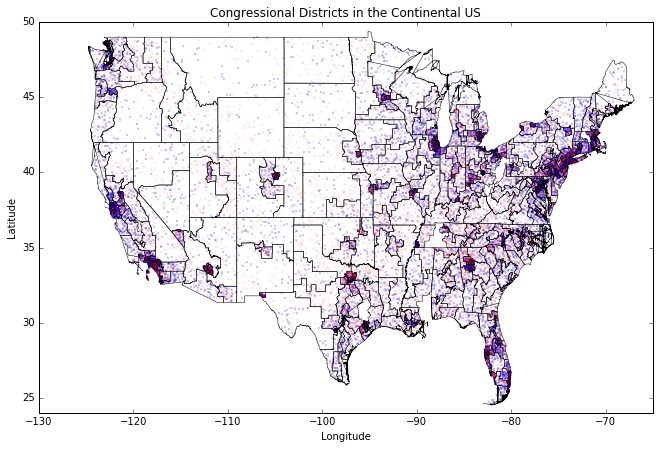

In [63]:
# Take a look at the distribution of our new citizens
# Note: This plot is mainly a sanity check before I run K-Means clustering-- visually 
# it tends to be dominated by whichever group is plotted last. I tried a randomized plotting
# approach which improved the visuals, but also took considerably longer. For now, I'm 
# satisfied that I'm grabbing what I think I'm grabbing.

n_people = scaled_ave_pop / 10
districts = 432
all_coord = np.zeros([n_people * districts,2])

plt.figure(figsize=(11,7))

for i in xrange(districts):
    
    # For clustering simplicity, ignore Hawaii, Alaska and territories for now
    territory_codes = [2, 15, 60, 66, 69, 72, 78 ]
    
    district = sf.records()[i]
    state_code = district[0]
    cd_code = district[1] # congressional district
    if int(state_code) in territory_codes : 
        continue
    
    # Need to translate from state code in shape file to state name in 
    # nation_cd113 file; need this translation to build proper query name
    # for DKE file to get percent dem/rep for population
    state = df_cd[df_cd['STATEFP'] == int(state_code)]['STATE']
    state_name =  np.array(state)[0]
    
    DKE_id = str(state_name) + "-" + str(cd_code)
        
    percent_dem_row = df_vote[ df_vote['CD'] == str(DKE_id) ]['Obama 2012']
    percent_dem = np.array(percent_dem_row)[0]
    
    # Now that we have our party affiliation breakdown, fill the district!
    party_v, coord_v = gen_pop_distribution(district_lines[i],\
                                            n_people, percent_dem)
    
    all_coord[i*n_people:(i+1)*n_people] = np.array(coord_v)
    
    dem = np.array([coord_v[j] for j in xrange(len(party_v)) if party_v[j] == 1])
    rep = np.array([coord_v[j] for j in xrange(len(party_v)) if party_v[j] == 0])
    
    #print "%i democrats and %i republicans " % (len(dem),len(rep))

    d = district_lines[i]
    pts = np.array(d.points).T
    
    plt.plot(dem[:,0],dem[:,1],'b.',ms=1,alpha=0.9)#,label='Democrats')
    plt.plot(rep[:,0],rep[:,1],'r.',ms=1,alpha=0.4)#,label='Republicans')   
    plt.plot(pts[0],pts[1],'k-',lw=0.5) #,label=DKE_id)
    

#plt.axis("off")
#plt.savefig("party_distribution.png", bbox_inches="tight")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim(-130,-65)
plt.ylim(24,50)
plt.title("Congressional Districts in the Continental US")
plt.show()

## Use K-Means Clustering to redraw district lines based only on population
Note: This takes on the order of minutes even a small number of iterations (I'm using a large number of districts + people)

In [56]:
# First step: Copy functions written during DL course homework 7.
# Adjust to limit representation size per new district to the current average (scaled)
def findClosestCentroids(X,centroids,n_people):
    
    idx = []
    cluster_limits = np.zeros([len(centroids),1])
    
    for x in X:
        min_dist = 1.e10
        min_c_it = -1
        c_it = 0

        for c in centroids:
            
            if cluster_limits[c_it] >= n_people:
                c_it += 1
                continue
            sq_dist = np.sum( np.square(x - c) )
            
            if sq_dist < min_dist:
                min_dist = sq_dist
                min_c_it = c_it
            c_it += 1
        
        cluster_limits[min_c_it] += 1 
        
        idx.append(min_c_it)
    
    return idx

def computeCentroids(X,centroids,idx_v):
    
    new_cents = np.array([])
    
    for c in xrange(centroids.shape[0]):
   
        x_per_c = [ X[i] for i in xrange(len(idx_v)) if idx_v[i] == c ]
        
        sum_c = np.cumsum(x_per_c,axis=0)[-1] / len(x_per_c)
        new_cents = np.append(new_cents,sum_c)
      
    #print "Finishing up an iteration... ", new_cents.shape, centroids.shape[0], X.shape[1]
    new_cents = new_cents.reshape(centroids.shape[0],X.shape[1])
    
    return new_cents

In [68]:
def runkMeans(X,iterations,k,n_people=0):
    
    k_init = random.sample(range(0,X.shape[0]),k)
    centroids = np.array([X[i] for i in k_init])
    prev_centroids = centroids

    for i in xrange(iterations):

        idx_v = findClosestCentroids(X,centroids,n_people)
        centroids = computeCentroids(X,centroids,idx_v)  
        prev_centroids = np.append(prev_centroids,centroids,axis=0)
        
    return centroids, idx_v, prev_centroids

def plotKMeansData(X,centroids,idx_v):
    
    plt.figure(figsize=(11,7))

    for c in xrange(centroids.shape[0]):
        c_it = np.array([ X[i] for i in xrange(len(idx_v)) if idx_v[i] == c ])
        
        if c_it.shape[0] == 0:  continue
        plt.plot(c_it[:,0],c_it[:,1],'.',ms=5,label="%i Clus"%c,alpha = 0.35)
        plt.grid(True)

In [60]:
iterations, k = 6, 432
centroids, idx_v, prev_centroids = runkMeans(all_coord,iterations,k,n_people)

(864,) 432 2
(864,) 432 2
(864,) 432 2
(864,) 432 2
(864,) 432 2
(864,) 432 2


(31104, 2) (432, 2) 31104


(-131, -65)

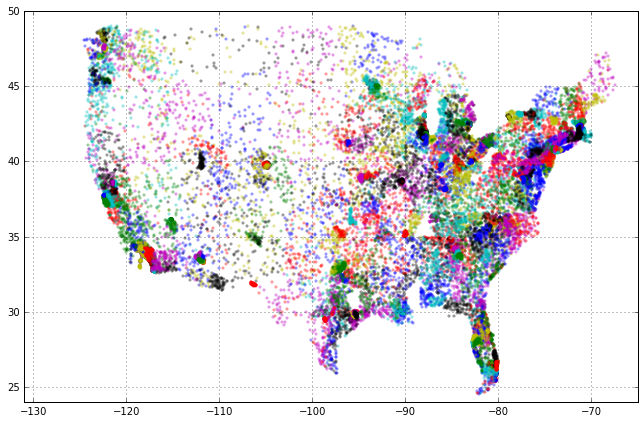

In [69]:
plotKMeansData(all_coord,centroids,idx_v)

plt.ylim(24,50)
plt.xlim(-131,-65)

I have used K means to build new districts, based on existing (scaled and averaged) population distributions. There are a number of other potential things here to explore:

0) So far I have only used a few iterations, as each takes some time to run. Increase this number + redraw boundaries

1) Ensure there are no gaps between new districts

2) Limit clustering distribution to state borders-- states would not like to share districts


In [62]:
# Also try to group colors on the map based on degree of overlap.  
# This currently works less well
#img = cv2.imread('Figures/party_distribution_v1.png')
#plt.axis("off")
#plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#img_kmeans = img.reshape([img.shape[0]*img.shape[1],img.shape[2]])

#iterations, k = 10, 8
#centroids, idx_v, prev_centroids = runkMeans(img_kmeans,iterations,k)

In [ ]:
# img2_kmeans = img_kmeans

# for i in xrange(img2_kmeans.shape[0]):
#     img2_kmeans[i] = centroids[ idx_v[i] ]

# img2_kmeans = img2_kmeans.reshape([img.shape[0],img.shape[1],img.shape[2]])
# plt.axis("off")
# plt.legend()
# plt.imshow(cv2.cvtColor(img2_kmeans, cv2.COLOR_BGR2RGB))
# plt.savefig("KMeans_v0.png")